# Part I

## Data Collection

In [3]:
# imports & functions
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy import text
from sqlalchemy.orm import Session
from datetime import datetime
import requests
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format

def connect_to_sql_server():
    try:
        driver='ODBC+Driver+18+for+SQL+Server'
        server = 'localhost'
        database = 'quant'
        username = 'loadtest'
        password = 'password123'

        connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}&Encrypt=no&charset=utf8"

        # Create engine and insert DataFrame
        engine = create_engine(connection_string)

        # Verify the connection
        print("Connected to SQL Server successfully!")

        return engine

    except Exception as ex:
        print(f"Error connecting to SQL Server: {ex}")
        return None, None  # Return None on error

def get_network_response(url: str, sleep_time=45, retry=5):
    response = requests.get(url)

    if response.status_code == 200:
        return json.loads(response.text)
    else:
        if '"code":"error.tooManyRequests"' in response.text and retry != 0:
            print(f'Retry number {retry}')
            retry -= 1
            time.sleep(sleep_time)
            return get_network_response(url, sleep_time=sleep_time, retry=retry)
        else:
            raise Exception(response.text)

def format_datetime(date: str):
    # Parse the datetime with UTC consideration
    datetime_obj = datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ')

    # Format the desired output (including milliseconds)
    formatted_date = datetime_obj.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]  # Truncate to 3 decimal places

    return formatted_date

# convert data to sql format for dml
def transform_data_to_sql(row):
    for index, value in row.items():
        if type(value) is int:
            row[index] = value
        elif type(value) is float and not pd.isna(value):
            row[index] = value
        elif type(value) is str:
            row[index] = f"N'{value}'"
        elif value is None or pd.isna(value) or value == 'nan':
            row[index] = f"NULL"
        elif value:
            row[index] = 1
        elif not value:
            row[index] = 0
        else:
            raise Exception(f"Datatype {type(value)} for column {index} is not supported yet.")
    return row

In [4]:
offline_df = pd.read_csv('./realstate_data_2014_2016 - EN.csv')
offline_df = offline_df.rename(columns=lambda x: x.strip())
offline_df['Data_Source'] = 'OFFLINE'
offline_df.rename(columns={'Advertisement Number': 'AD_Number'
, 'Fore sale or Rent': 'AD_Purpose'
, 'Closed': 'AD_Status'
, 'Creation Time': 'Created_At'
, 'Last Update Time': 'Updated_At'
, 'Type of Advertiser': 'Advertiser_Type'
, 'Residential or Commercial': 'Usage_Type' 
, 'Families or Singls': 'Accommodation_Type'
, 'Property Type': 'Property_Type'
, 'Age Less Than': 'Property_Age'
, 'Rental Period': 'Rent_Type'
, 'Number of Rooms': 'Room_Count'
, 'Number of Bathrooms': 'Toilets_Count'
, 'Number of Living Rooms': 'Halls_Count'
, 'Maid\'s Room': 'Has_Maid_Room'
, 'Swimming Pool': 'Has_Pool'
, 'Driver Room': 'Has_Driver_Room'
, 'Number of Kitchens': 'Has_Kitchen_Installed'
, 'Price': 'Price'
, 'Area Dimension': 'Property_Area'
, 'Street Direction': 'Property_Face'
, 'Street Width': 'Street_Width'
, 'district_name_ar': 'District_Name_Ar'
, 'district_name_en': 'District_Name_En'
, 'Zip Code No': 'Zip_Code'
, 'nearest_city_name_ar': 'City_Name_Ar'
, 'region_name_ar': 'Region_Name_Ar'
}, inplace=True)
offline_df = offline_df[offline_df['District_Name_Ar'].isin(['الياسمين', 'الملقا'])]
offline_df.head()

,AD_Number,User Number,Created_At,Updated_At,Property_Age,Number of Appartment,Number of Beadrooms,Floor,Has_Kitchen_Installed,AD_Status,Usage_Type,Property_Type,Has_Driver_Room,Duplex,Accommodation_Type,Furnished,Halls_Count,Has_Maid_Room,Price per Meter,Advertiser_Type,Has_Pool,Paid,Price,Rent_Type,Room_Count,Property_Area,Property_Face,Street_Width,AD_Purpose,Toilets_Count,Latitude,Longitude,Region_Name_Ar,region_name_en,province_name,City_Name_Ar,nearest_city_name_en,District_Name_Ar,District_Name_En,Zip_Code,Data_Source
9,117248,2124,9/29/2016 12:48,10/5/2016 15:48,0,0,0,0,0,متاح,تجاري,أرض,لا يوجد غرفة سائق,ليست دوبلكس,عزاب,لا يوجد اثاث,0,لا يوجد غرفة خادمة,3300,مسوق,لا يوجد مسبح,مجاني,1320000.00,غير محدد,0,400,شرق,30,للبيع,0,24.82,46.60,الرياض,Riyadh,الدرعية,الوصيل,AL WUSAYL,الملقا,Al Malqa,13525.00,OFFLINE
13,72027,18985,6/17/2016 4:39,6/30/2016 14:14,0,0,0,0,0,مغلق,سكني,أرض,لا يوجد غرفة سائق,ليست دوبلكس,عزاب,لا يوجد اثاث,0,لا يوجد غرفة خادمة,2000,مسوق,لا يوجد مسبح,مجاني,1800000.00,غير محدد,0,900,شمال,15,للبيع,0,24.82,46.61,الرياض,Riyadh,الدرعية,الوصيل,AL WUSAYL,الملقا,Al Malqa,13524.00,OFFLINE
15,126752,21145,5/9/2015 13:02,5/9/2015 13:02,0,0,2,3,1,مغلق,غير محدد,شقة,لا يوجد غرفة سائق,ليست دوبلكس,عوائل,لا يوجد اثاث,1,لا يوجد غرفة خادمة,0,مسوق,لا يوجد مسبح,مجاني,24000.00,سنوي,0,0,غير محدد,0,للإيجار,1,24.81,46.60,الرياض,Riyadh,الدرعية,أبا الكباش,ABA AL KIBASH,الملقا,Al Malqa,13525.00,OFFLINE
28,80556,212,7/16/2016 14:46,7/24/2016 16:26,0,0,5,1,0,مغلق,غير محدد,دور,لا يوجد غرفة سائق,ليست دوبلكس,عزاب,لا يوجد اثاث,1,لا يوجد غرفة خادمة,0,مسوق,لا يوجد مسبح,مجاني,45000.00,غير محدد,0,420,شرق,0,للإيجار,4,24.83,46.64,الرياض,Riyadh,الرياض,الوصيل,AL WUSAYL,الياسمين,Al Yasmin,13325.00,OFFLINE
33,72580,26962,6/18/2016 18:18,8/2/2016 20:24,1,0,4,0,1,متاح,غير محدد,شقة,لا يوجد غرفة سائق,ليست دوبلكس,عوائل,لا يوجد اثاث,1,لا يوجد غرفة خادمة,0,مسوق,لا يوجد مسبح,مجاني,600000.00,غير محدد,0,164,شمال شرقي,35,للبيع,4,24.82,46.65,الرياض,Riyadh,الرياض,الدرعية,AD DIR'IYAH,الياسمين,Al Yasmin,13326.00,OFFLINE


In [5]:
# Stansraize values with data from DealApp
offline_df.loc[offline_df["AD_Purpose"] == "للبيع", "AD_Purpose"] = 'SALE'
offline_df.loc[offline_df["AD_Purpose"] == "للإيجار", "AD_Purpose"] = 'RENT'
offline_df.loc[offline_df["AD_Status"] == "مغلق", "AD_Status"] = 'CLOSED'
offline_df.loc[offline_df["AD_Status"] == "متاح", "AD_Status"] = 'AVAILABLE'
offline_df.loc[offline_df["AD_Status"] == "غير منشور", "AD_Status"] = 'NOT PUBLISHED'
offline_df.loc[offline_df["Advertiser_Type"] == "مسوق", "Advertiser_Type"] = 'BROKER'
offline_df.loc[offline_df["Advertiser_Type"] == "مالك", "Advertiser_Type"] = 'OWNER'
offline_df.loc[offline_df["Usage_Type"] == "تجاري", "Usage_Type"] = 'COMMERCIAL'
offline_df.loc[offline_df["Usage_Type"] == "سكني", "Usage_Type"] = 'RESIDENTIAL'
offline_df.loc[offline_df["Usage_Type"] == "غير محدد", "Usage_Type"] = 'NOT SPECIFIED'
offline_df.loc[offline_df["Usage_Type"] == "كلاهما", "Usage_Type"] = 'BOTH'
offline_df.loc[offline_df["Accommodation_Type"] == "عوائل", "Accommodation_Type"] = 'FAMILY'
offline_df.loc[offline_df["Accommodation_Type"] == "عزاب", "Accommodation_Type"] = 'SINGLES'
offline_df.loc[offline_df["Accommodation_Type"] == "#NAME?", "Accommodation_Type"] = 'UKNOWN'
offline_df.loc[offline_df["Usage_Type"].isin(['4', '5', '6', '7']), "Usage_Type"] = 'UKNOWN'
offline_df.loc[offline_df["Rent_Type"] == "سنوي", "Rent_Type"] = 'ANNUALLY'
offline_df.loc[offline_df["Rent_Type"] == "شهري", "Rent_Type"] = 'MONTHLY'
offline_df.loc[offline_df["Rent_Type"] == "يومي", "Rent_Type"] = 'DAILY'
offline_df.loc[offline_df["Rent_Type"] == "غير محدد", "Rent_Type"] = 'NOT SPECIFIED'
offline_df.loc[offline_df["Rent_Type"].isin(['4', '5', '6']), "Rent_Type"] = 'UKNOWN'
offline_df.loc[offline_df["Has_Maid_Room"] == "غرفة خادمة", "Has_Maid_Room"] = True
offline_df.loc[offline_df["Has_Maid_Room"] == "لا يوجد غرفة خادمة", "Has_Maid_Room"] = False
offline_df.loc[offline_df["Has_Pool"] == "مسبح", "Has_Pool"] = True
offline_df.loc[offline_df["Has_Pool"] == "لا يوجد مسبح", "Has_Pool"] = False
offline_df.loc[offline_df["Has_Driver_Room"] == "غرفة سائق", "Has_Driver_Room"] = True
offline_df.loc[offline_df["Has_Driver_Room"] == "لا يوجد غرفة سائق", "Has_Driver_Room"] = False
offline_df.loc[offline_df["Has_Kitchen_Installed"] > 0, "Has_Kitchen_Installed"] = True
offline_df.loc[offline_df["Has_Kitchen_Installed"] == 0, "Has_Kitchen_Installed"] = False
offline_df.loc[offline_df["Region_Name_Ar"] == "الرياض", "Region_Name_Ar"] = "منطقة الرياض"

offline_df.head()

,AD_Number,User Number,Created_At,Updated_At,Property_Age,Number of Appartment,Number of Beadrooms,Floor,Has_Kitchen_Installed,AD_Status,Usage_Type,Property_Type,Has_Driver_Room,Duplex,Accommodation_Type,Furnished,Halls_Count,Has_Maid_Room,Price per Meter,Advertiser_Type,Has_Pool,Paid,Price,Rent_Type,Room_Count,Property_Area,Property_Face,Street_Width,AD_Purpose,Toilets_Count,Latitude,Longitude,Region_Name_Ar,region_name_en,province_name,City_Name_Ar,nearest_city_name_en,District_Name_Ar,District_Name_En,Zip_Code,Data_Source
9,117248,2124,9/29/2016 12:48,10/5/2016 15:48,0,0,0,0,False,AVAILABLE,COMMERCIAL,أرض,False,ليست دوبلكس,SINGLES,لا يوجد اثاث,0,False,3300,BROKER,False,مجاني,1320000.00,NOT SPECIFIED,0,400,شرق,30,SALE,0,24.82,46.60,منطقة الرياض,Riyadh,الدرعية,الوصيل,AL WUSAYL,الملقا,Al Malqa,13525.00,OFFLINE
13,72027,18985,6/17/2016 4:39,6/30/2016 14:14,0,0,0,0,False,CLOSED,RESIDENTIAL,أرض,False,ليست دوبلكس,SINGLES,لا يوجد اثاث,0,False,2000,BROKER,False,مجاني,1800000.00,NOT SPECIFIED,0,900,شمال,15,SALE,0,24.82,46.61,منطقة الرياض,Riyadh,الدرعية,الوصيل,AL WUSAYL,الملقا,Al Malqa,13524.00,OFFLINE
15,126752,21145,5/9/2015 13:02,5/9/2015 13:02,0,0,2,3,True,CLOSED,NOT SPECIFIED,شقة,False,ليست دوبلكس,FAMILY,لا يوجد اثاث,1,False,0,BROKER,False,مجاني,24000.00,ANNUALLY,0,0,غير محدد,0,RENT,1,24.81,46.60,منطقة الرياض,Riyadh,الدرعية,أبا الكباش,ABA AL KIBASH,الملقا,Al Malqa,13525.00,OFFLINE
28,80556,212,7/16/2016 14:46,7/24/2016 16:26,0,0,5,1,False,CLOSED,NOT SPECIFIED,دور,False,ليست دوبلكس,SINGLES,لا يوجد اثاث,1,False,0,BROKER,False,مجاني,45000.00,NOT SPECIFIED,0,420,شرق,0,RENT,4,24.83,46.64,منطقة الرياض,Riyadh,الرياض,الوصيل,AL WUSAYL,الياسمين,Al Yasmin,13325.00,OFFLINE
33,72580,26962,6/18/2016 18:18,8/2/2016 20:24,1,0,4,0,True,AVAILABLE,NOT SPECIFIED,شقة,False,ليست دوبلكس,FAMILY,لا يوجد اثاث,1,False,0,BROKER,False,مجاني,600000.00,NOT SPECIFIED,0,164,شمال شرقي,35,SALE,4,24.82,46.65,منطقة الرياض,Riyadh,الرياض,الدرعية,AD DIR'IYAH,الياسمين,Al Yasmin,13326.00,OFFLINE


In [6]:
offline_df['Null_Count'] = offline_df.isnull().sum(axis=1)
offline_df[offline_df['Null_Count']!=0]

# Sort by 'Null Count' in ascending order
offline_df = offline_df.sort_values('Null_Count')

# Drop duplicates based on AD_Number, keeping the first occurrence
offline_df = offline_df.drop_duplicates(subset=['AD_Number'], keep='first')

In [ ]:
ads_url = "https://api.dealapp.sa/production/ad?page=<page_number>&sort=-1&sortBy=refreshed.at&city=6009d941950ada00061eeeab&district=5dd490aebc2e91004242e4df,5dd490aebc2e91004242e4e1"
ad_url = "https://api.dealapp.sa/production/ad/<ad_number>"

ads_overview_data = get_network_response(ads_url.replace('<page_number>', '1'))
total_page = ads_overview_data['totalPage']
data = []

for page in range(1, total_page + 1):
    ads_data = get_network_response(ads_url.replace('<page_number>', str(page)))
    print(f'page number: {page}')
    for ad in ads_data['data']:
        ad_number = ad['code']
        print(f'ad_number: {ad_number}')
        ad = get_network_response(ad_url.replace('<ad_number>', str(ad_number)))
        data.append({
                'AD_Number': ad['data']['code'],
                'AD_Purpose': ad['data']['purpose'],
                'AD_Status': 'AVAILABLE',
                'Created_At': format_datetime(ad['data']['createdAt']),
                'Updated_At': format_datetime(ad['data']['updatedAt']),
                'Advertiser_Type': ad['data']['createdBy']['agentType'],
                'Usage_Type': ad['data']['relatedQuestions']['usageType'][0] if len(ad['data']['relatedQuestions']['usageType']) > 0 else None,
                'Accommodation_Type': ad['data']['relatedQuestions']['accommodationType'] if 'accommodationType' in ad['data']['relatedQuestions'] else None,
                'Property_Type': ad['data']['propertyType']['propertyType_ar'],
                'Property_Age': ad['data']['propertyAge'],
                'Rent_Type': ad['data']['rentType'] if 'rentType' in ad['data'] else None,
                'Room_Count': ad['data']['relatedQuestions']['roomsNum'] if 'roomsNum' in ad['data']['relatedQuestions'] else None,
                'Toilets_Count': ad['data']['relatedQuestions']['toiletsNum'] if 'toiletsNum' in ad['data'] else None,
                'Halls_Count': ad['data']['relatedQuestions']['hallsNum'] if 'hallsNum' in ad['data']['relatedQuestions'] else None,
                'Has_Maid_Room': ad['data']['relatedQuestions']['hasMaidRoom'] if 'hasMaidRoom' in ad['data']['relatedQuestions'] else None,
                'Has_Pool': ad['data']['relatedQuestions']['hasPool'] if 'hasPool' in ad['data']['relatedQuestions'] else None,
                'Has_Driver_Room': ad['data']['relatedQuestions']['hasDriverRoom'] if 'hasDriverRoom' in ad['data']['relatedQuestions'] else None,
                'Has_Kitchen_Installed': ad['data']['relatedQuestions']['isKitchenInstalled'] if 'isKitchenInstalled' in ad['data']['relatedQuestions'] else None,
                'Price': ad['data']['price'],
                'Property_Area': ad['data']['regaRawData']['propertyArea'],
                'Property_Face': ad['data']['propertyFace'] if 'propertyFace' in ad['data'] else None,
                'Street_Width': ad['data']['regaRawData']['streetWidth'],
                'District_Name_Ar': ad['data']['district']['name_ar'],
                'District_Name_En': ad['data']['district']['name_en'],
                'Zip_Code': ad['data']['regaRawData']['location']['postalCode'],
                'City_Name_Ar': ad['data']['regaRawData']['location']['city'],
                'Region_Name_Ar': ad['data']['regaRawData']['location']['region'],
                'Data_Source': 'DEALAPP'
                }
        )

dealapp_df = pd.DataFrame(data)

In [8]:
ads_df = pd.concat([offline_df, dealapp_df], join='inner')

# Remove '.0' from the end of strings using lambda function
ads_df['Zip_Code'] = ads_df['Zip_Code'].astype(str)
ads_df['Zip_Code'] = ads_df['Zip_Code'].apply(lambda x: x[:-2] if x.endswith('.0') else x)

## Data Warehousing

In [9]:
query = f'SELECT ID, AD_Number, AD_Purpose, AD_Status, Created_At, Updated_At, Advertiser_Type, Usage_Type, Accommodation_Type, Property_Type, Property_Age, Rent_Type, Room_Count, Toilets_Count, Halls_Count, Has_Maid_Room, Has_Pool, Has_Driver_Room, Has_Kitchen_Installed, Price, Property_Area, Property_Face, Street_Width, District_Name_Ar, District_Name_En, Zip_Code, City_Name_Ar, Region_Name_Ar, Data_Source \
FROM quant.dbo.AD_Details;'

engine = connect_to_sql_server()

# Create session and query
with Session(engine) as session:
    ad_details = session.execute(text(query))
    ad_details_df = pd.DataFrame(ad_details)

print(f'Size of the table in datawarehouse `{len(ad_details_df)}`')

Connected to SQL Server successfully!
Size of the table in datawarehouse `10220`


In [10]:
merged_df = pd.DataFrame()
new_ads_df = pd.DataFrame()
updated_ads_df = pd.DataFrame()
closed_ads_df = pd.DataFrame()

if len(ad_details_df) > 0:
    ad_details_df = ad_details_df.rename(columns={'AD_Number': 'AD_Number_ad_details'})
    merged_df = pd.merge(ad_details_df, ads_df, how='outer', left_on=['AD_Number_ad_details', 'Data_Source'], right_on=['AD_Number', 'Data_Source'], suffixes=('_ad_details', ''))
    new_ads_df = merged_df[merged_df['AD_Number_ad_details'].isna()]
    updated_ads_df = merged_df[merged_df['Updated_At_ad_details'] < merged_df['Updated_At']]
    closed_ads_df = merged_df[(merged_df['AD_Number'].isna()) & (merged_df['AD_Status_ad_details'] != 'CLOSED')]
else:
    new_ads_df = ads_df

print(f'new ads: {len(new_ads_df)}')
print(f'updated ads: {len(updated_ads_df)}')
print(f'closed ads: {len(closed_ads_df)}')

new ads: 3
updated ads: 149
closed ads: 0


In [11]:
values = []
insert_dmls = []

if len(new_ads_df) > 0:
    for index, row in new_ads_df.iterrows():
        row = transform_data_to_sql(row)
        values.append(f"{row['AD_Number']}, {row['AD_Purpose']}, {row['AD_Status']}, \
            {row['Created_At']}, {row['Updated_At']}, {row['Advertiser_Type']}, {row['Usage_Type']}, {row['Accommodation_Type']},\
            {row['Property_Type']}, {row['Property_Age']}, {row['Rent_Type']}, {row['Room_Count']}, \
            {row['Toilets_Count']}, {row['Halls_Count']}, {row['Has_Maid_Room']}, {row['Has_Pool']}, \
            {row['Has_Driver_Room']}, {row['Has_Kitchen_Installed']}, {row['Price']}, {row['Property_Area']}, \
            {row['Property_Face']},{row['Street_Width']}, {row['District_Name_Ar']}, \
            {row['District_Name_En']}, {row['Zip_Code']}, {row['City_Name_Ar']}, {row['Region_Name_Ar']}, {row['Data_Source']} \
            ")

    threshold = 1000
    lower = 0
    upper = threshold
    while True:
        insert_dmls.append(f"INSERT INTO quant.dbo.AD_Details (AD_Number, AD_Purpose, AD_Status, Created_At, Updated_At, Advertiser_Type, Usage_Type, Accommodation_Type, Property_Type, Property_Age, Rent_Type, Room_Count, Toilets_Count, Halls_Count, Has_Maid_Room, Has_Pool, Has_Driver_Room, Has_Kitchen_Installed, Price, Property_Area, Property_Face, Street_Width, District_Name_Ar, District_Name_En, Zip_Code, City_Name_Ar, Region_Name_Ar, Data_Source) \
            VALUES {', '.join([f'({data})' for data in values[lower:upper]])}")
        if len(values) < upper:
            if len(values) <= lower:
                insert_dmls = insert_dmls[:-1]
            break
        lower = upper
        upper += threshold

In [12]:
update_dmls = []

if len(updated_ads_df) > 0:
    for index, row in updated_ads_df.iterrows():
        row = transform_data_to_sql(row)
        update_dmls.append(f"UPDATE quant.dbo.AD_Details SET \
            AD_Purpose = {row['AD_Purpose']}, AD_Status = {row['AD_Status']}, Created_At = {row['Created_At']}, Updated_At = {row['Updated_At']}, \
            Advertiser_Type = {row['Advertiser_Type']}, Usage_Type = {row['Usage_Type']}, Accommodation_Type = {row['Accommodation_Type']}, \
            Property_Type = {row['Property_Type']}, Property_Age = {row['Property_Age']}, Rent_Type = {row['Rent_Type']}, Room_Count = {row['Room_Count']}, \
            Toilets_Count = {row['Toilets_Count']}, Halls_Count = {row['Halls_Count']}, Has_Maid_Room = {row['Has_Maid_Room']}, Has_Pool = {row['Has_Pool']}, \
            Has_Driver_Room = {row['Has_Driver_Room']}, Has_Kitchen_Installed = {row['Has_Kitchen_Installed']}, Price = {row['Price']}, Property_Area = {row['Property_Area']}, \
            Property_Face = {row['Property_Face']}, Street_Width = {row['Street_Width']}, District_Name_Ar = {row['District_Name_Ar']}, \
            District_Name_En = {row['District_Name_En']}, Zip_Code = {row['Zip_Code']}, City_Name_Ar = {row['City_Name_Ar']}, Region_Name_Ar = {row['Region_Name_Ar']} \
            WHERE ID = {row['ID']} \
            ")

if len(closed_ads_df) > 0:
    for index, row in closed_ads_df.iterrows():
        row = transform_data_to_sql(row)
        update_dmls.append(f"UPDATE quant.dbo.AD_Details \
            SET [AD_Status] = 'CLOSED', [Updated_At] = GETDATE() \
            WHERE ID = {row['ID']} \
            ")

In [13]:
from sqlalchemy import text
from sqlalchemy.orm import Session

engine = connect_to_sql_server()

if insert_dmls:
    for insert_dml in insert_dmls:
        # create session and add objects
        with Session(engine) as session:
            session.execute(text(insert_dml))
            session.commit()

if update_dmls:
    for update_dml in update_dmls:
        # create session and add objects
        with Session(engine) as session:
            session.execute(text(update_dml))
            session.commit()

Connected to SQL Server successfully!


# Part II

In [14]:
query = f'SELECT ID, AD_Number, AD_Purpose, AD_Status, Created_At, Updated_At, Advertiser_Type, Usage_Type, Accommodation_Type, Property_Type, Property_Age, Rent_Type, Room_Count, Toilets_Count, Halls_Count, Has_Maid_Room, Has_Pool, Has_Driver_Room, Has_Kitchen_Installed, Price, Property_Area, Property_Face, Street_Width, District_Name_Ar, District_Name_En, Zip_Code, City_Name_Ar, Region_Name_Ar, Data_Source \
FROM quant.dbo.AD_Details;'

engine = connect_to_sql_server()

# Create session and query
with Session(engine) as session:
    ad_details = session.execute(text(query))
    ad_details_df = pd.DataFrame(ad_details)

print(f'Size of the table in datawarehouse `{len(ad_details_df)}`')

Connected to SQL Server successfully!
Size of the table in datawarehouse `10223`


## Calculate the average rate increase in rent prices when switching from a 2-Bedroom Apartment to a 3-bedroom Apartment in Riyadh for both families and singles.

In [15]:
# Filter data for apartments, RENT purpose, and AVAILABLE status
apartments = ad_details_df[
    (ad_details_df['Property_Type'].isin(['شقة في مجمع سكني', 'شقة', 'شقة مفروشة', 'دور'])) &
    (ad_details_df['AD_Purpose'] == 'RENT') & 
    (ad_details_df['AD_Status'] == 'AVAILABLE')
]

# Filter for 2-bedroom and 3-bedroom apartments
two_bedroom_apartments = apartments[apartments['Room_Count'] == 2]
three_bedroom_apartments = apartments[apartments['Room_Count'] == 3]

# Calculate average prices for each Accommodation_Type and bedroom count
two_bedroom_apartments_avg_prices = two_bedroom_apartments.groupby(['Accommodation_Type', 'Rent_Type','Room_Count'])['Price'].mean().reset_index()
three_bedroom_apartments_avg_prices = three_bedroom_apartments.groupby(['Accommodation_Type', 'Rent_Type', 'Room_Count'])['Price'].mean().reset_index()

# Combine the two DataFrames
avg_prices = pd.concat([two_bedroom_apartments_avg_prices, three_bedroom_apartments_avg_prices])

# Create a pivot table
pivot_table = avg_prices.pivot_table(index=['Accommodation_Type', 'Rent_Type'], columns='Room_Count', values='Price')

pivot_table = pivot_table.dropna()

# Calculate the rate increase, handling missing values with fillna(0)
pivot_table['Rate_Increase'] = ((pivot_table[3].fillna(0) - pivot_table[2].fillna(0)) / pivot_table[2].fillna(0)) * 100

pivot_table['Rate_Increase'] = pivot_table[['Rate_Increase']].round(2)

# Display the results
print(pivot_table)

Room_Count                        2.0      3.0  Rate_Increase
Accommodation_Type Rent_Type                                 
FAMILY             ANNUALLY  76363.64 99153.85          29.84
                   MONTHLY    9375.00 16300.00          73.87


## Calculate the average duration it takes to close a post and mention the parameters that affect this duration. Also, mention the district with the shortest duration it takes to close a post with property type of villa

In [20]:
# Convert `Created_At` and `Updated_At` to datetime
ad_details_df['Created_At'] = pd.to_datetime(ad_details_df['Created_At'])
ad_details_df['Updated_At'] = pd.to_datetime(ad_details_df['Updated_At'])

# Calculate the duration to close a post in days
ad_details_df['Duration_To_Close'] = (ad_details_df['Updated_At'] - ad_details_df['Created_At']).dt.days

# Filter for closed posts
closed_posts = ad_details_df[ad_details_df['AD_Status'] == 'CLOSED']

# Calculate the average duration to close a post
average_duration = closed_posts['Duration_To_Close'].mean()
print(f'Average duration to close a post: {average_duration:.2f} days\n')

# Parameters affecting closing duration
parameters = ['Property_Age', 'Room_Count', 'Toilets_Count', 'Halls_Count', 'Property_Area', 'Street_Width']

# Analyze correlation between parameters and duration
correlations = closed_posts[parameters + ['Duration_To_Close']].corr(numeric_only = False)['Duration_To_Close']
print("Correlation between parameters and duration to close:")
print(correlations.sort_values(ascending=False).to_string())

# Filter for villas in Riyadh and find the district with the shortest duration
riyadh_villas = closed_posts[(closed_posts['Property_Type'].isin(['فيلا مع شقتين', 'فيلا', 'فيلا مع شقة', 'بيت']))]
if not riyadh_villas.empty:
  shortest_duration_district = riyadh_villas.loc[riyadh_villas['Duration_To_Close'].idxmin(), 'District_Name_Ar']
  print(f'\nDistrict with shortest duration to close a villa post in Riyadh: {shortest_duration_district}')
else:
  print("\nNo villa posts found in Riyadh.")

Average duration to close a post: 47.91 days

Correlation between parameters and duration to close:
Duration_To_Close    1.00
Street_Width         0.18
Halls_Count          0.06
Toilets_Count        0.05
Room_Count           0.01
Property_Area       -0.01
Property_Age        -0.06

District with shortest duration to close a villa post in Riyadh: الملقا


## Provide the correlation matrix for the effects on prices after normalization for both rents and sales, and comment on the most price affecting parameters.

In [21]:
# Filter for rent and sales data
rent_data = ad_details_df[ad_details_df['AD_Purpose'] == 'RENT']
sales_data = ad_details_df[ad_details_df['AD_Purpose'] == 'SALE']

# Parameters to consider for correlation analysis
parameters = ['Property_Age', 'Room_Count', 'Toilets_Count', 'Halls_Count', 'Property_Area', 'Street_Width']

for data in [rent_data, sales_data]:
    data['Normalized_Price'] = (data['Price'] - data['Price'].min()) / (data['Price'].max() - data['Price'].min())

# Calculate correlation matrices for rent and sales data
rent_correlations = rent_data[parameters + ['Normalized_Price']].corr(numeric_only = False)['Normalized_Price']
sales_correlations = sales_data[parameters + ['Normalized_Price']].corr(numeric_only = False)['Normalized_Price']

# Display the correlation matrices
print("Correlation Matrix for Rent Prices (Normalized):\n")
print(rent_correlations.sort_values(ascending=False).to_string())

print("\nCorrelation Matrix for Sales Prices (Normalized):\n")
print(sales_correlations.sort_values(ascending=False).to_string())


Correlation Matrix for Rent Prices (Normalized):

Normalized_Price    1.00
Toilets_Count       0.03
Property_Age        0.02
Street_Width        0.02
Property_Area       0.00
Halls_Count        -0.00
Room_Count         -0.00

Correlation Matrix for Sales Prices (Normalized):

Normalized_Price    1.00
Halls_Count         0.01
Toilets_Count       0.01
Property_Area       0.00
Room_Count         -0.00
Property_Age       -0.00
Street_Width       -0.00


## Give a sales price valuation of rental properties (convert rental properties to sales properties) based on 6% ROI (Return on Investment) then estimate the meter price distribution per property type and district and comment on the result

In [18]:
# Filter for rental properties with `Rent_Type` ANNUALLY, MONTHLY and DAILY
rent_data = ad_details_df[(ad_details_df['AD_Purpose'] == 'RENT') & \
      (ad_details_df['Rent_Type'].isin(['ANNUALLY', 'MONTHLY', 'DAILY'])) & \
      (ad_details_df['Property_Area'].notna()) & \
      (ad_details_df['Property_Area'] != 0)]

# Convert 'Price' to numeric, handling errors
rent_data['Price'] = pd.to_numeric(rent_data['Price'], errors='coerce')

# List of conditions
conditions = [
      (rent_data['Rent_Type'] == 'ANNUALLY'),
      (rent_data['Rent_Type'] == 'MONTHLY'),
      (rent_data['Rent_Type'] == 'DAILY')
]
# List of values to return
choices  = [
      rent_data['Price'],
      rent_data['Price'] * 12,
      rent_data['Price'] * 365
]
# Calculate annual rent based on the conditions
rent_data["Annual_Rent"] = np.select(conditions, choices, "ERROR")

# Convert 'Price' to numeric, handling errors
rent_data['Annual_Rent'] = pd.to_numeric(rent_data['Annual_Rent'], errors='coerce')

# Calculate sales price valuation based on 6% ROI
rent_data['Sales_Price_Valuation'] = rent_data['Annual_Rent'] / 0.06

# Calculate meter price for rental properties
rent_data['Meter_Price'] = rent_data['Sales_Price_Valuation'] / rent_data['Property_Area'].astype(float)

# Group by `Property_Type`` and `District_Name_Ar`` to get meter price distribution
meter_price_distribution = rent_data.groupby(['Property_Type', 'District_Name_Ar'])['Meter_Price'].describe().reset_index()

# Display the meter price distribution
print("\nMeter Price Distribution per Property Type and District:\n")
meter_price_distribution[['Property_Type', 'District_Name_Ar', 'count', 'mean', 'std', 'min', 'max']]


Meter Price Distribution per Property Type and District:



,Property_Type,District_Name_Ar,count,mean,std,min,max
0,أرض,الملقا,3.00,1755154.32,1660500.23,60833.33,3379629.63
1,استراحة,الملقا,27.00,6851.51,5941.76,1500.00,30416.67
2,استراحة,الياسمين,11.00,8791.64,15416.29,3.74,53333.33
3,دور,الملقا,5.00,512466.67,501092.48,2916.67,1135555.56
4,دور,الياسمين,26.00,400565.09,492253.99,1555.56,1520833.33
5,شقة,الملقا,164.00,178749.78,805651.41,3.59,6506238.86
6,شقة,الياسمين,102.00,199403.18,1019994.47,321.48,8111111.11
7,شقة في مجمع سكني,الملقا,1.00,7575.76,NaN,7575.76,7575.76
8,شقة مفروشة,الملقا,1.00,24770.64,NaN,24770.64,24770.64
9,عمارة,الملقا,5.00,2102166.14,1948374.13,5407.41,3881746.03


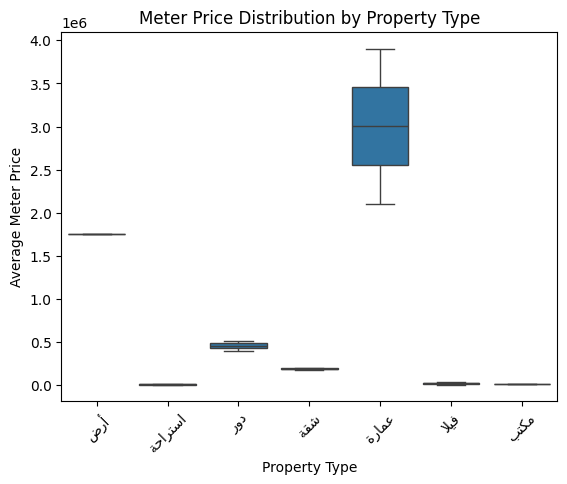

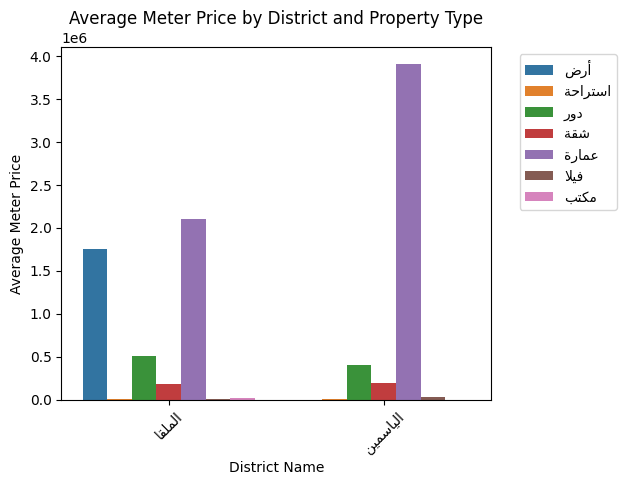

In [19]:
# Filter out rows where `count`` is less than a threshold (e.g., 2) to avoid unreliable statistics
threshold = 2 
filtered_data = meter_price_distribution[meter_price_distribution['count'] >= threshold]

# Format arabic letters
filtered_data['Property_Type'] = [get_display(arabic_reshaper.reshape(data)) for data in filtered_data['Property_Type']]
filtered_data['District_Name_Ar'] = [get_display(arabic_reshaper.reshape(data)) for data in filtered_data['District_Name_Ar']]

# Convert `mean`` column to numeric for plotting
filtered_data['mean'] = pd.to_numeric(filtered_data['mean'])

# Box plot for Meter Price distribution by Property Type
sns.boxplot(x='Property_Type', y='mean', data=filtered_data)
plt.title('Meter Price Distribution by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Average Meter Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# ar plot to compare average Meter Price across districts for each property type
sns.barplot(x='District_Name_Ar', y='mean', hue='Property_Type', data=filtered_data)
plt.title('Average Meter Price by District and Property Type')
plt.xlabel('District Name')
plt.ylabel('Average Meter Price')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()